In [51]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

from scipy.io import savemat, loadmat

import tensorflow as tf
print(tf. __version__)

2.10.0


In [52]:
def unpack_data(data):
    Q = data['Q'][0]
    IQ_I = data['IQ_I'][0]
    IQ_er_I = data['IQ_er_I'][0]
    q_ext = data['q_ext'][0]
    IQ_ext = data['IQ_ext'][0]
    sigma = data['sigma'][0]
    fp = data['fp'][0]
    fp_std = data['fp_std'][0]
    fp_Z = data['fp_Z'][0]
    fp_std_Z = data['fp_std_Z'][0]
    
    return Q, IQ_I, IQ_er_I, q_ext, IQ_ext, sigma, fp, fp_std, fp_Z, fp_std_Z
    
rr = np.linspace(0.01, 10.0, 200)
ur_hc = 4*500*((2**(1/6)/rr)**12-(2**(1/6)/rr)**6-0.25)
ur_hc[rr>=1] = 0

def sample_potential(fp,fp_err):
    n_sample = 100
    
    kappa = fp[1]
    kappa_std = fp_err[1]
    A = fp[2]
    A_std = fp_err[2]
    
    ur_sample = np.zeros((tf.size(rr),n_sample))
    for i in range(n_sample):
        kappa_sample = np.random.normal()*(kappa_std) + kappa
        A_sample = np.random.normal()*(A_std) + A
        ur_sample[:,i] = A_sample*np.exp(-(rr-1)/kappa_sample)/rr + ur_hc
        
    ur_std = np.std(ur_sample,axis=1)
    ur_mean = np.mean(ur_sample,axis=1)
        
    return ur_mean, ur_std

def sample_potential_GT(fp):
    kappa = fp[1]
    A = fp[2]
    
    ur = A*np.exp(-(rr-1)/kappa)/rr + ur_hc
        
    return ur

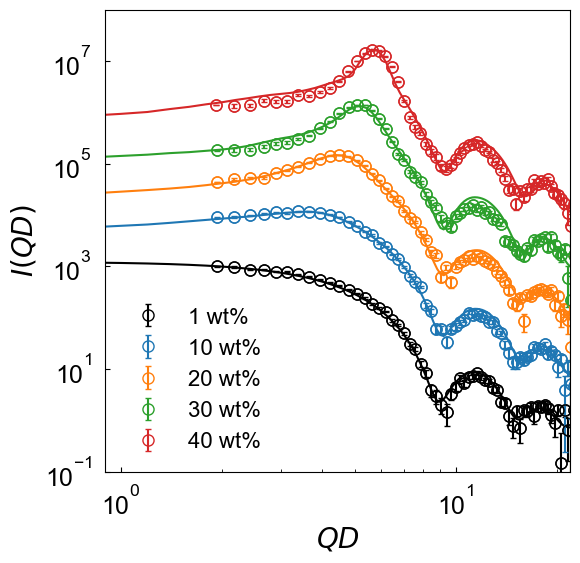

In [72]:
W_list = [10,20,30,40]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

color_list = ['C0','C1','C2','C3','C4']

# 1%
data = loadmat('results_10.mat')
Q, IQ_I, IQ_er_I, q_ext, IQ_ext, sigma, fp, fp_std, fp_Z, fp_std_Z = unpack_data(data)
IQ_P = data['IQ_P'][0]
IQ_er_P = data['IQ_er_P'][0]
IQ_fit_P = data['IQ_fit_P'][0]
ax.plot(Q*sigma*1e10,IQ_P,'o',color='k',fillstyle='none',ms=8)
ax.errorbar(Q*sigma*1e10,IQ_P,IQ_er_P,label='1 wt%',
            linestyle='',fmt='o',color='k',capsize=2,fillstyle='none',ms=8)
ax.plot(q_ext, IQ_fit_P,'-',color='k')

# 10% to 40%
for i, W in enumerate(W_list):
    filename = 'results_{}.mat'.format(W)
    data = loadmat(filename)
    Q, IQ_I, IQ_er_I, q_ext, IQ_ext, sigma, fp, fp_std, fp_Z, fp_std_Z = unpack_data(data)

    ax.plot(Q*sigma*1e10,IQ_I*10**i*5,'o',color=color_list[i],fillstyle='none',ms=8)
    ax.errorbar(Q*sigma*1e10,IQ_I*10**i*5,IQ_er_I*10**i*5,label='{} wt%'.format(W),
                linestyle='',fmt='o',color=color_list[i],capsize=2,fillstyle='none',ms=8)

    ax.plot(q_ext, IQ_ext*10**i*5,'-',color=color_list[i])

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim([0.9,22])
ax.set_ylim([1e-1,1e8])
ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend(fontsize=16,frameon=False)

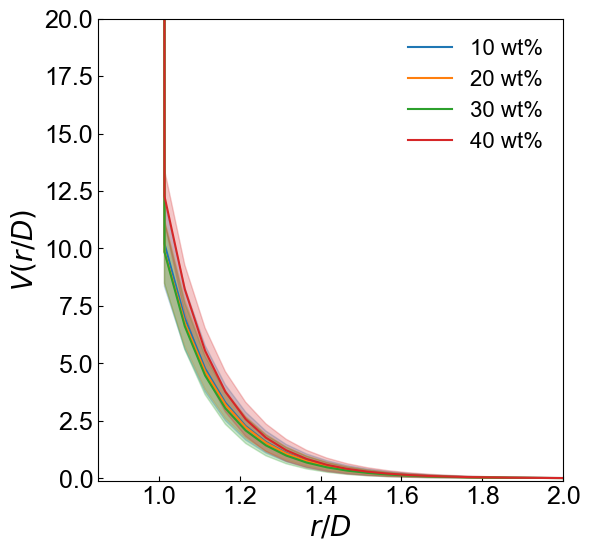

In [54]:
W_list = [10,20,30,40]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

color_list = ['C0','C1','C2','C3','C4']

for i, W in enumerate(W_list):
    filename = 'results_{}.mat'.format(W)
    data = loadmat(filename)
    Q, IQ_I, IQ_er_I, q_ext, IQ_ext, sigma, fp, fp_std, fp_Z, fp_std_Z = unpack_data(data)
    
    ur_NN, ur_NN_std = sample_potential(fp,fp_std)
    
    ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,
                    color=color_list[i],alpha=0.25)
    ax.plot(rr,ur_NN,color=color_list[i],label='{} wt%'.format(W))

ax.set_xlim(0.85,2.0)
ax.set_ylim(-0.1,20)
ax.set_xlabel(r'$r/D$',fontsize=20)
ax.set_ylabel(r'$V(r/D)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax.legend(fontsize=16,frameon=False)

In [56]:
## make table
def print_table(data,W):
    Q, IQ_I, IQ_er_I, q_ext, IQ_ext, sigma, fp, fp_std, fp_Z, fp_std_Z = unpack_data(data)

    index_print = [0,1,2]
    string_NN = ''
    for j in index_print:
        string_NN += '{:0.4f}$\pm${:0.4f}'.format(fp[j],fp_std[j])
        if j<3:
            string_NN += ' & '
    string_NN += '{:0.4f}$\pm${:0.4f}'.format(fp_Z[0],fp_std_Z[0])
    string_W = '{} wt\% & '.format(W)
    string_row = string_W + string_NN+r'\\'
    print(string_row)

print(r'\begin{tabular}{ccccc}')
print('\hline')
print('\hline')
print(r' & $\phi$ & $1/\kappa D$ & $AD$ & $Z$\\')
for i, W in enumerate(W_list):
    filename = 'results_{}.mat'.format(W)
    data = loadmat(filename)
    print('\hline')
    print_table(data,W)
print('\hline')
print('\end{tabular}')

\begin{tabular}{ccccc}
\hline
\hline
 & $\phi$ & $1/\kappa D$ & $AD$ & $Z$\\
\hline
10 wt\% & 0.0694$\pm$0.0072 & 0.1501$\pm$0.0223 & 11.2963$\pm$1.8789 & 39.9993$\pm$5.6527\\
\hline
20 wt\% & 0.1432$\pm$0.0035 & 0.1539$\pm$0.0170 & 10.8040$\pm$1.5554 & 38.3747$\pm$4.2485\\
\hline
30 wt\% & 0.2289$\pm$0.0001 & 0.1478$\pm$0.0256 & 11.0027$\pm$1.4697 & 39.9535$\pm$5.9616\\
\hline
40 wt\% & 0.2995$\pm$0.0000 & 0.1499$\pm$0.0290 & 13.7912$\pm$1.3175 & 44.2442$\pm$6.9007\\
\hline
\end{tabular}


|          | $\phi$           | $1/\kappa D$     | $AD$             | $Z$              |
|----------|------------------|------------------|------------------|------------------|
| 10 wt\%  | 0.0694±0.0072    | 0.1501±0.0223    | 11.2963±1.8789    | 39.9993±5.6527    |
| 20 wt\%  | 0.1432±0.0035    | 0.1539±0.0170    | 10.8040±1.5554    | 38.3747±4.2485    |
| 30 wt\%  | 0.2289±0.0001    | 0.1478±0.0256    | 11.0027±1.4697    | 39.9535±5.9616    |
| 40 wt\%  | 0.2995±0.0000    | 0.1499±0.0290    | 13.7912±1.3175    | 44.2442±6.9007    |
